# Imports

In [2]:
import pandas             as pd
import numpy              as np
import seaborn            as sns
import inflection
import math
import datetime

from IPython.core.display  import HTML
from IPython.display       import Image
from matplotlib            import pyplot     as plt
from tabulate              import tabulate
from scipy                 import stats      as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn               import preprocessing
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy

ModuleNotFoundError: No module named 'boruta'

## Helper Functions

In [2]:
def personal_settings():
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
        
    # notebook settings
    display(HTML('<style>.container{width:90% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)

        
    # seaborn settings
    sns.set(rc={'figure.figsize':(15,10)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.5)
    
   
def cramer_v (x,y):
    cm = pd.crosstab(x,y).to_numpy() # contingency matriz
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1);
    rcorr = r - (r-1)**2/(n-1);
    
    return np.sqrt ( (chi2corr/n) / (min (kcorr-1, rcorr-1)) )

In [3]:
personal_settings();

## Loading Data

In [4]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merging datsets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# DATA DESCRIPTION

In [5]:
df1=df_raw.copy()

## Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']


# changing the name of the columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# renaming dataset columns
df1.columns = cols_new
print(df1.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


## Data Dimension

In [8]:
print('Number of rows: {}' .format(df1.shape[0]))
print('Number of columns: {}' .format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## Data Types

In [9]:
print(df1.dtypes)
df1.head()

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


## Check NA 

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [11]:
# ======= competition_distance

#checking maximum value
df1['competition_distance'].max() # The maximum distance is:  75860.0

# replacing each NA
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:2000000.0 if math.isnan(x) else (x))

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

#  ======= competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#  ======= competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [13]:
# ======= promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# ======= promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


In [14]:
# ======= promo_interval

month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# filling Na with "0"
df1['promo_interval'].fillna(0, inplace=True)

# finding the month name given month number by mapping the "month_map" dictionary
df1 ['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0
                                                                  else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                                  else 0, axis=1 )

In [15]:
df1[['competition_distance','competition_open_since_month','competition_open_since_year',
     'promo2_since_week','promo2_since_year','promo_interval', 'month_map', 'is_promo']].sample(5)

,competition_distance,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
539558,680.00,3.00,2014.00,22.00,2012.00,"Jan,Apr,Jul,Oct",Mar,0
863144,850.00,2.00,2012.00,40.00,2014.00,"Jan,Apr,Jul,Oct",May,0
911208,70.00,6.00,1990.00,22.00,2012.00,"Mar,Jun,Sept,Dec",Apr,0
398477,8240.00,3.00,2001.00,10.00,2013.00,"Feb,May,Aug,Nov",Jul,0
765714,5470.00,8.00,2013.00,37.00,2009.00,"Jan,Apr,Jul,Oct",Ago,0


## Change Variable Types

In [16]:
print(df1.dtypes)
df1.sample()

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
221922,38,2,2015-01-13,5644,509,1,1,0,0,d,a,1090.00,4.00,2007.00,0,3.00,2015.00,0,Jan,0


In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## Descriptive Statistical

In [18]:
num_df1 = df1.select_dtypes(include=['int64','float64'])
cat_df1 = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [21]:
# central tendendy - mean, median
ct1 = pd.DataFrame(num_df1.apply(np.mean)).T
ct2 = pd.DataFrame(num_df1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_df1.apply(np.std)).T
d2 = pd.DataFrame(num_df1.apply(min)).T
d3 = pd.DataFrame(num_df1.apply(max)).T
d4 = pd.DataFrame(num_df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_df1.apply(lambda x: x.kurtosis)).T

# concatenate 
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,<bound method NDFrame._add_numeric_operations....
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,<bound method NDFrame._add_numeric_operations....
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,<bound method NDFrame._add_numeric_operations....
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,<bound method NDFrame._add_numeric_operations....
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,<bound method NDFrame._add_numeric_operations....
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,<bound method NDFrame._add_numeric_operations....
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,<bound method NDFrame._add_numeric_operations....
7,competition_distance,20.00,2000000.00,1999980.00,10610.59,2330.00,101810.65,19.38,<bound method NDFrame._add_numeric_operations....
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,<bound method NDFrame._add_numeric_operations....
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,<bound method NDFrame._add_numeric_operations....


### Categorical Attributes

In [22]:
cat_df1.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

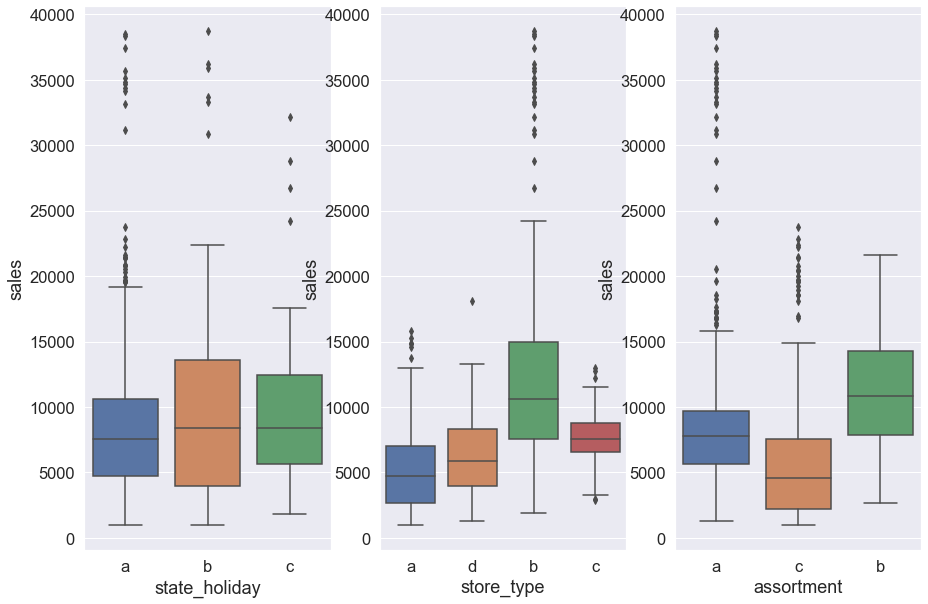

In [23]:
# filtering sales that happened during a state holiday
aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# FEATURE ENGINEERING

In [24]:
df2=df1.copy()

## Mind Map Hypothesis 

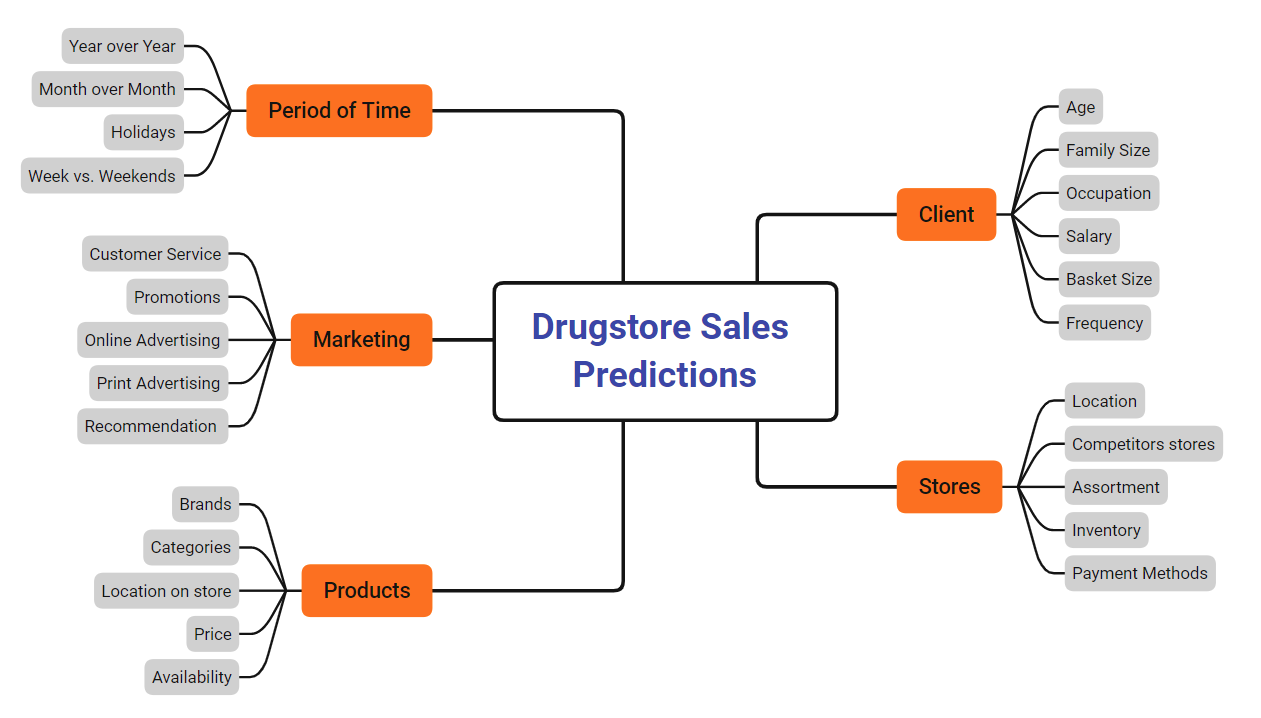

In [25]:
# importing hipothesis mind map
Image('../image/MindMapHypothesis.png')

## Creating Hypothesis

### Store Hypothesis 
1. Stores with bigger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more. 

### Product Hypothesis
4. Stores with longer active promotions should sell more.

5. Stores with more consecutive promotions should sell more.

### Periodicity Hypothesis
6. Stores sell more during the Christmas holiday than during other holidays.

8. Stores should sell more over the years.

9. Stores should sell more in the second semester.

10. Stores should sell more after the 10th of each month.

11. Stores should sell less on weekends.

12. Stores should sell less during school holidays.

## Feature Engineering

In [26]:
df2 = df1.copy()
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4,2015,0,31,2015,0,Jul,0


In [27]:
# creating 'year' from 'date'
df2['year'] = df2['date'].dt.year

# creating 'month' from 'date'
df2['month'] = df2['date'].dt.month

# creating 'day' from 'date'
df2['day'] = df2['date'].dt.day

# creating 'week_of_year' from 'date'
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# creating 'year_week' from 'date'
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [28]:
print(df2[['date','year','month','day','week_of_year','year_week']].dtypes)
df2[['date','year','month','day','week_of_year','year_week']].head()

date            datetime64[ns]
year                     int64
month                    int64
day                      int64
week_of_year             int64
year_week               object
dtype: object


,date,year,month,day,week_of_year,year_week
0,2015-07-31,2015,7,31,31,2015-30
1,2015-07-31,2015,7,31,31,2015-30
2,2015-07-31,2015,7,31,31,2015-30
3,2015-07-31,2015,7,31,31,2015-30
4,2015-07-31,2015,7,31,31,2015-30


In [29]:
# creating 'competition_open_since' by combining 'competition_open_since_year and 'competition_open_since_month'
df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# creating 'competition_open_timeinmonths' by calculating the difference between 'date' and 'competition_open_since':
df2['competition_open_timeinmonths'] = ((df2['date']-df2['competition_open_since'])/30).apply(lambda x: x.days).astype('int64')

In [30]:
print(df2[['date','competition_open_since_year','competition_open_since_month',
           'competition_open_since','competition_open_timeinmonths']].dtypes)

df2[['date','competition_open_since_year','competition_open_since_month',
     'competition_open_since','competition_open_timeinmonths']].head()

date                             datetime64[ns]
competition_open_since_year               int64
competition_open_since_month              int64
competition_open_since           datetime64[ns]
competition_open_timeinmonths             int64
dtype: object


,date,competition_open_since_year,competition_open_since_month,competition_open_since,competition_open_timeinmonths
0,2015-07-31,2008,9,2008-09-01,84
1,2015-07-31,2007,11,2007-11-01,94
2,2015-07-31,2006,12,2006-12-01,105
3,2015-07-31,2009,9,2009-09-01,71
4,2015-07-31,2015,4,2015-04-01,4


In [31]:
# creating 'promo_since' by combining 'promo2_since_year' and 'promo2_since_week'
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) # string type (year-week, ex: 2015-31)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))  # date type (yyyy-mm-dd)

# creating 'promo_since_timeinweeks' by calculating the difference between 'date' and 'promo_since':
df2['promo_since_timeinweeks'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(np.int64)

In [32]:
print(df2[['date','promo2_since_year','promo2_since_week','promo_since','promo_since_timeinweeks']].dtypes)

df2[['date','promo2_since_year','promo2_since_week','promo_since','promo_since_timeinweeks']].head()

date                       datetime64[ns]
promo2_since_year                   int64
promo2_since_week                   int64
promo_since                datetime64[ns]
promo_since_timeinweeks             int64
dtype: object


,date,promo2_since_year,promo2_since_week,promo_since,promo_since_timeinweeks
0,2015-07-31,2015,31,2015-07-27,0
1,2015-07-31,2010,13,2010-03-22,279
2,2015-07-31,2011,14,2011-03-28,226
3,2015-07-31,2015,31,2015-07-27,0
4,2015-07-31,2015,31,2015-07-27,0


In [33]:
# changing 'assortment' attribute by given classification
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' 
                                                 else 'extra' if x=='b' 
                                                 else 'extended')

In [34]:
print(df2[['assortment']].dtypes)

df2[['assortment']].head()

assortment    object
dtype: object


,assortment
0,basic
1,basic
2,basic
3,extended
4,basic


In [35]:
# changing 'sate_holiday' attribute by given classification
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'Public holiday' if x=='a' 
                                                        else 'Easter holiday' if x=='b' 
                                                        else 'Christmas'      if x=='c'
                                                        else 'regular day')

In [36]:
print(df2[['state_holiday']].dtypes)

df2[['state_holiday']].head()

state_holiday    object
dtype: object


,state_holiday
0,regular day
1,regular day
2,regular day
3,regular day
4,regular day


# VARIABLE FILTERING

In [37]:
df3=df2.copy()

## Lines Filtering

In [38]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## Columns Selections

In [39]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [40]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_open_since',
       'competition_open_timeinmonths', 'promo_since',
       'promo_since_timeinweeks'],
      dtype='object')

# EDA

In [41]:
df4=df3[df3['date']<'2015-01-01'].copy() # filtering year for better analysis

In [42]:
num_df4 = df4.select_dtypes(include=['int64','float64'])
cat_df4 = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## Univariate Analysis

### Response Variable

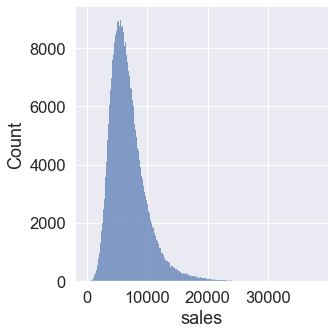

In [43]:
sns.displot(df4['sales'], legend=True, kde=False);

### Numerical Variables

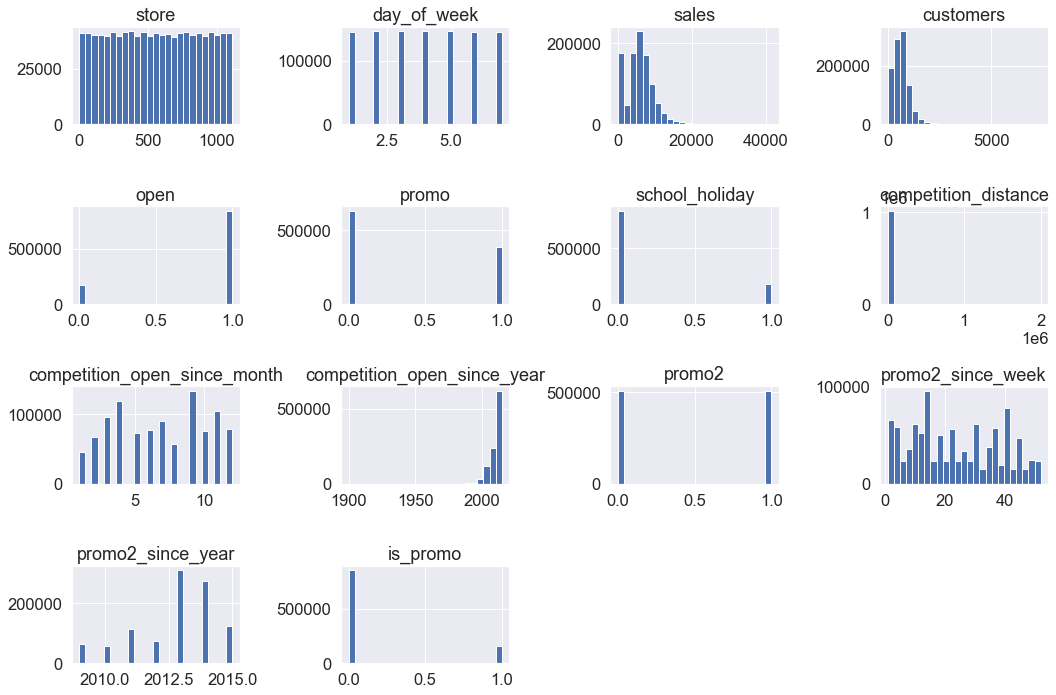

In [44]:
num_df1.hist(bins=25);
plt.tight_layout()

### Categorical Variables

In [287]:
cat_df1.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


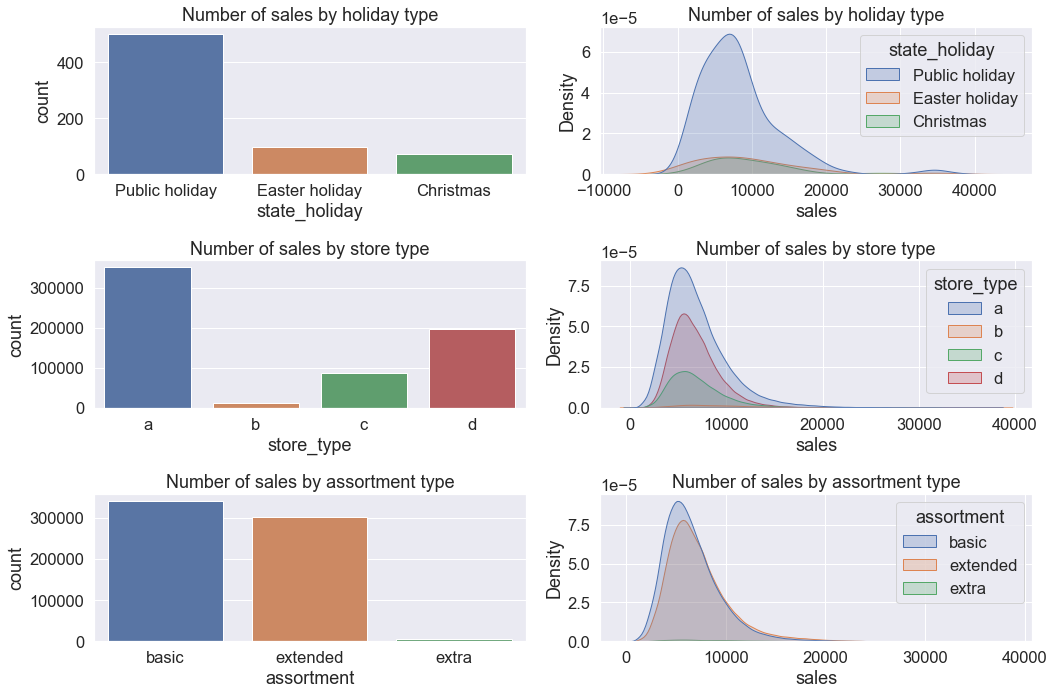

In [45]:
# sales by 'state_holiday'
a = df4[df4['state_holiday']!='regular day']
plt.subplot(3,2,1)
sns.countplot(data=a, x=a["state_holiday"], order=['Public holiday', 'Easter holiday', 'Christmas']).set_title("Number of sales by holiday type")

plt.subplot(3,2,2)
sns.kdeplot(data=a, x='sales', hue='state_holiday', hue_order=['Public holiday', 'Easter holiday', 'Christmas'], fill=True).set_title("Number of sales by holiday type");


# sales by 'store_type'
plt.subplot(3,2,3)
sns.countplot(data=df4, x=df4['store_type'], order=['a', 'b', 'c', 'd']).set_title("Number of sales by store type")

plt.subplot(3,2,4)
sns.kdeplot(data=df4, x="sales", hue="store_type", hue_order=['a', 'b', 'c', 'd'], fill=True).set_title("Number of sales by store type")


# sales by 'assortment'
plt.subplot(3,2,5)
sns.countplot(data=df4, x=df4['assortment'], order=['basic', 'extended', 'extra']).set_title("Number of sales by assortment type");

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x="sales", hue="assortment", hue_order=['basic', 'extended', 'extra'], fill=True).set_title("Number of sales by assortment type");

plt.tight_layout()

## Bivariate Analysis

Hypothesis Resume

In [46]:
tab = [ ['Hypothesis', 'Conclusion', 'Relevance', 'Conclusion'],
        ['H1','True', 'Low',  'Stores with bigger assortment sell more on average.'],
        ['H2','False','High', 'Stores with closer competitors sell more.'],
        ['H3','False','Low',  'Stores with longer competitors should sell less.'],
        ['H4','False','High', 'Stores with longer active promotions sell less after a certain period of time'],
        ['H5','False','High', 'Stores with more consecutive promotions sell less.'],
        ['H6','True' ,'High', 'Stores sell more during the Christmas holiday than during other holidays'],
        ['H7','False','High', 'Stores are selling less over the years.'],
        ['H8','True', 'High', 'Stores sell more in the second semester.'],
        ['H9','False','High', ' Stores sell less after the 10th of each month.'],
        ['H10','False','High', 'Stores sell more on weekends.'],
        ['H11','False','High', 'Stores sell more during school holidays.'],
        
      ]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis    Conclusion    Relevance    Conclusion
------------  ------------  -----------  -----------------------------------------------------------------------------
H1            True          Low          Stores with bigger assortment sell more on average.
H2            False         High         Stores with closer competitors sell more.
H3            False         Low          Stores with longer competitors should sell less.
H4            False         High         Stores with longer active promotions sell less after a certain period of time
H5            False         High         Stores with more consecutive promotions sell less.
H6            True          High         Stores sell more during the Christmas holiday than during other holidays
H7            False         High         Stores are selling less over the years.
H8            True          High         Stores sell more in the second semester.
H9            False         High         Stores sell less after the 10th of

### Stores with bigger assortment should sell more.
**True:** Stores with bigger assortment sell more on average.

assortment,basic,extended,extra
avg_sales,6612.76,7229.01,8364.17
qty_stores,340937.00,301071.00,6301.00


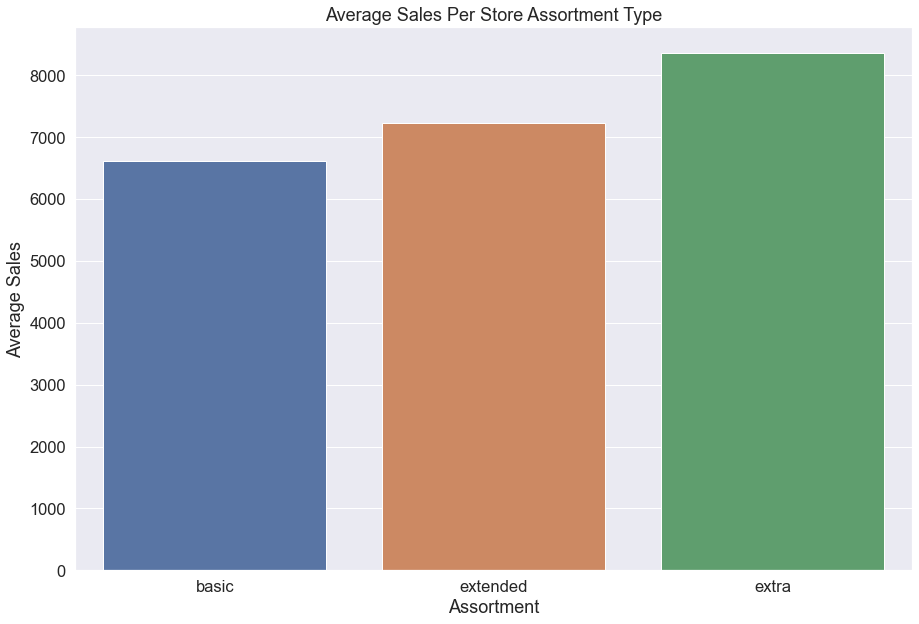

In [47]:
# checking 'sales' by 'assortoment'
a = df4[['store','assortment', 'sales']].copy()

b = (a.groupby('assortment').agg(qty_stores = ('store', 'count'),
                                 avg_sales  = ('sales', 'mean'))).reset_index()

c = pd.pivot_table(b, columns='assortment')
display(c)

ax = sns.barplot(data=b, x='assortment', y='avg_sales');
ax.set(xlabel="Assortment", ylabel="Average Sales", title="Average Sales Per Store Assortment Type");

### Stores with closer competitors should sell less.
**False:** Stores with closer competitors sell more.

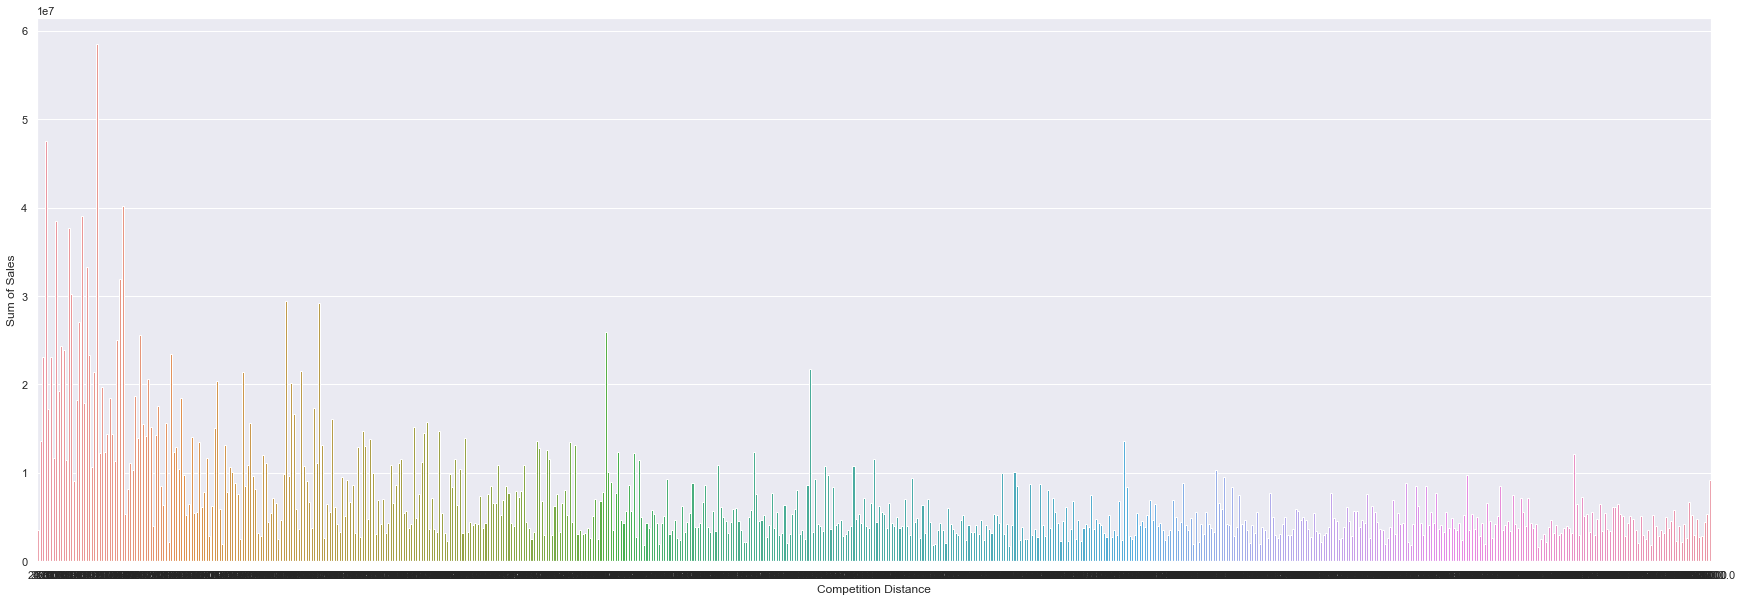

In [50]:
# checking sales by 'competition_distance'
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.set(rc={'figure.figsize':(30,10)})
sns.barplot(data = aux1, x='competition_distance', y='sales').set(xlabel='Competition Distance', ylabel='Sum of Sales');
personal_settings();

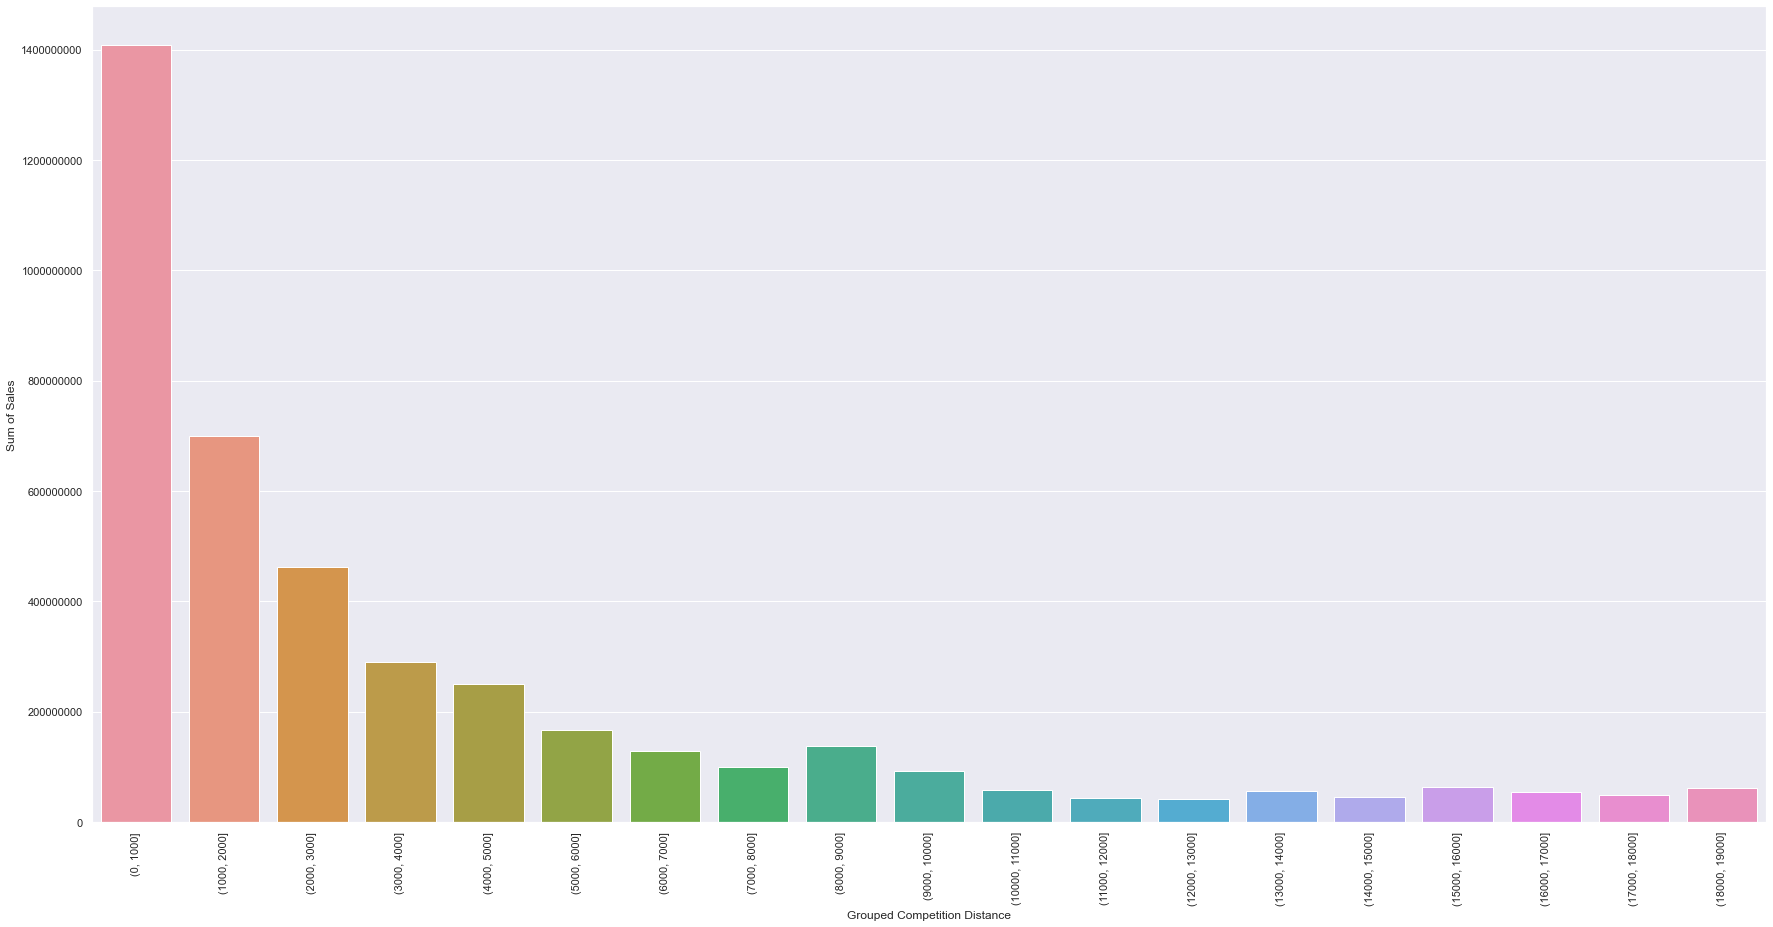

In [51]:
# grouping 'competition_distance' in bins
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bingroup = list (np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bingroup)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
#display(aux2.head())
sns.set(rc={'figure.figsize':(30,15)})
sns.barplot(data=aux2, x='competition_distance_binned', y='sales').set(xlabel='Grouped Competition Distance', ylabel='Sum of Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90);
personal_settings();

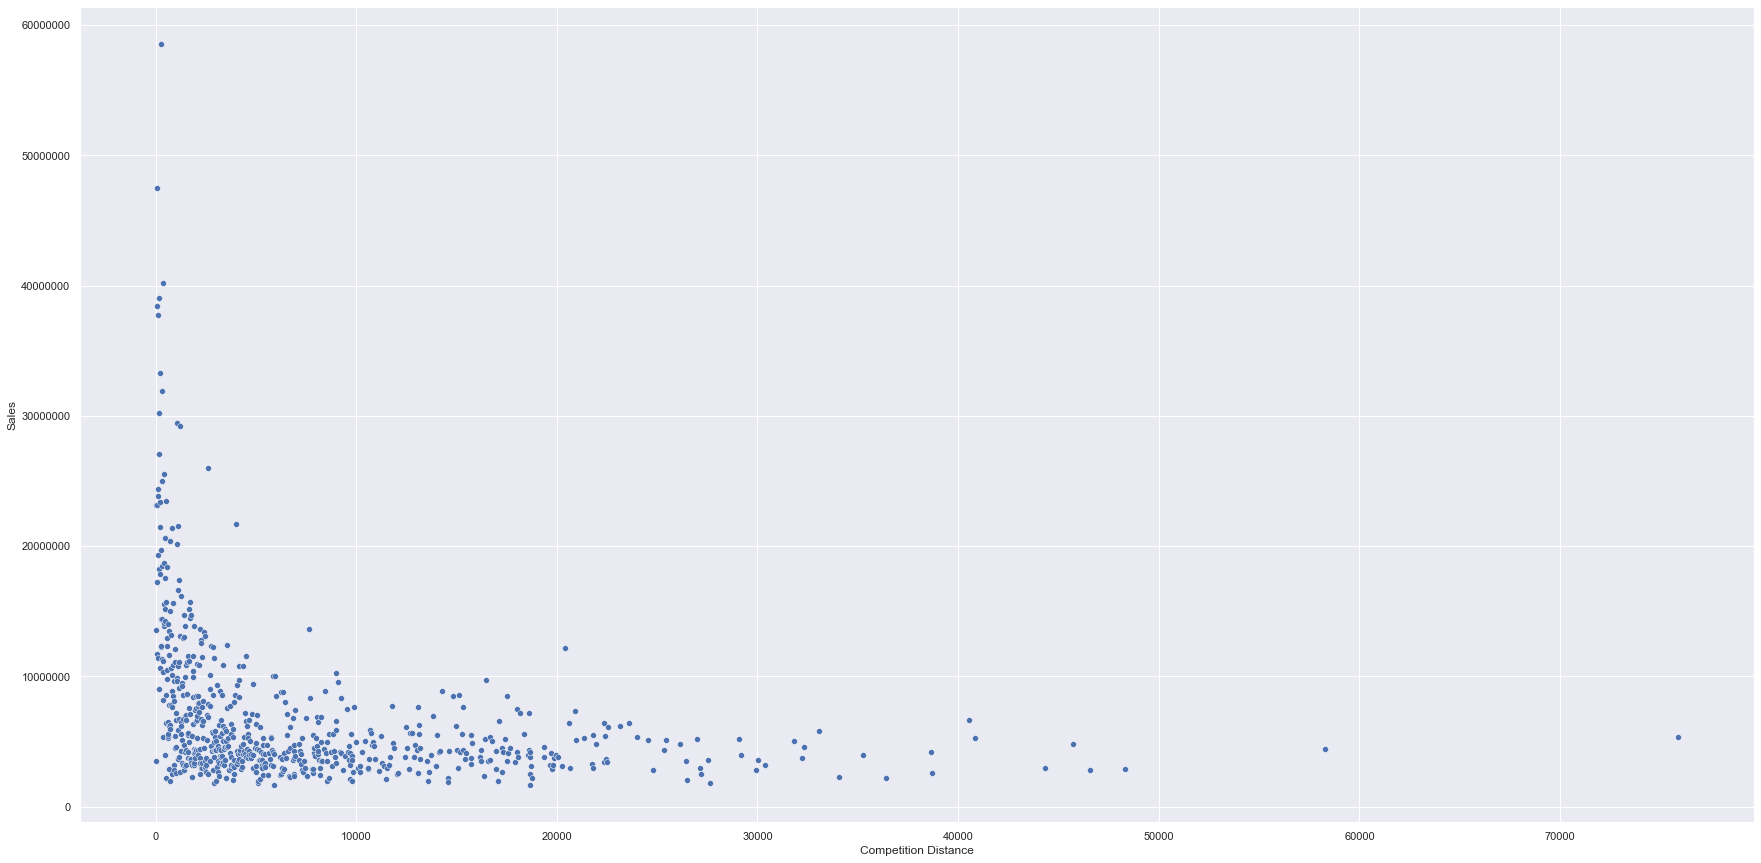

In [52]:
# checking 'competition_distance' distribution
aux1 = df4[df4['competition_distance']!=2000000][['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

sns.set(rc={'figure.figsize':(30,15)})
sns.scatterplot(data=aux1, x='competition_distance', y='sales').set(xlabel='Competition Distance', ylabel='Sales');
plt.ticklabel_format(style='plain', axis='y')
personal_settings();







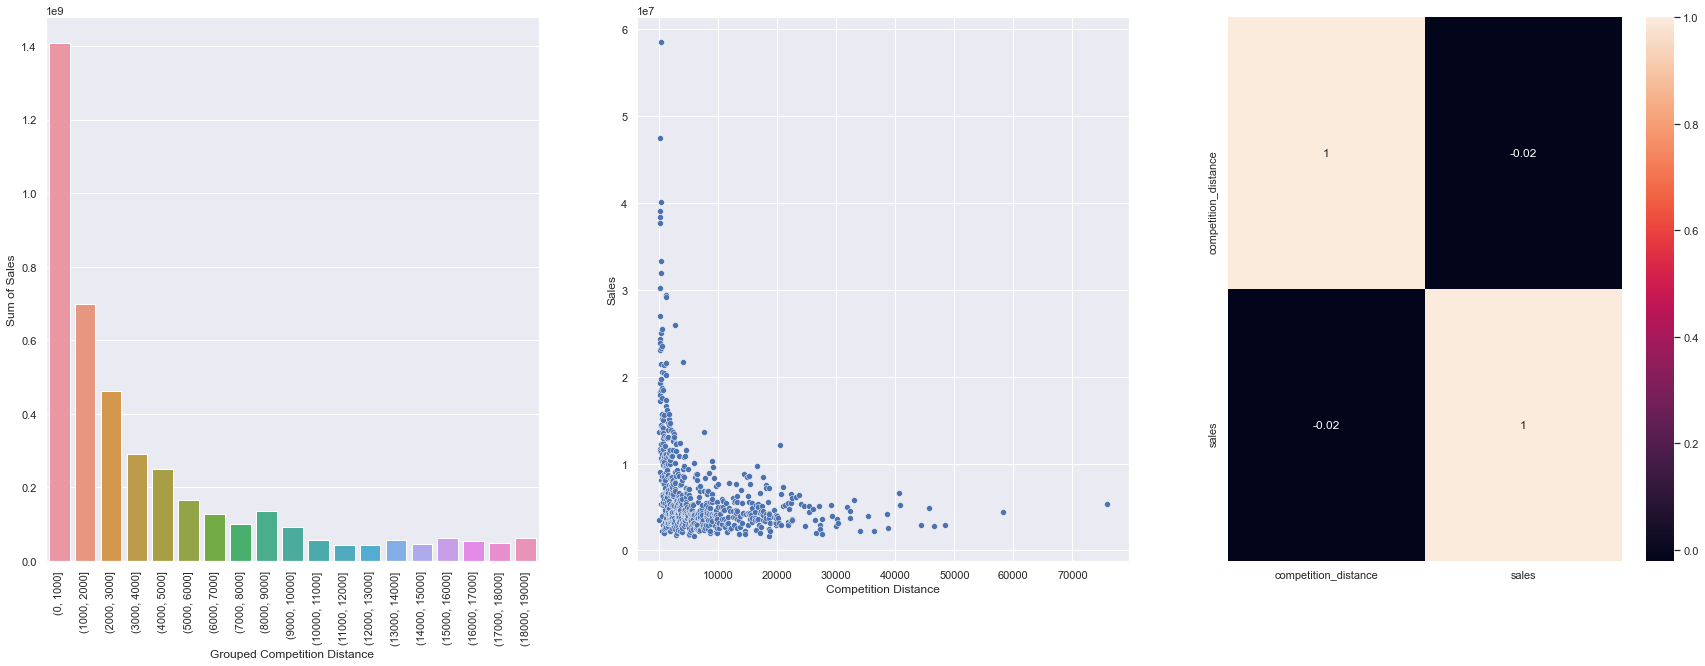

In [53]:
# comparing
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.set(rc={'figure.figsize':(30, 10)})

plt.subplot (1,3,1)
bingroup = list (np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bingroup)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales').set(xlabel='Grouped Competition Distance', ylabel='Sum of Sales')
plt.xticks(rotation=90);

plt.subplot (1,3,2)
aux2 = aux1[aux1['competition_distance']!=2000000]
sns.scatterplot(data=aux2, x='competition_distance', y='sales').set(xlabel='Competition Distance', ylabel='Sales');

plt.subplot (1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
personal_settings();

### Stores with longer competitors should sell more.
**False:** Stores with longer competitors should sell less.

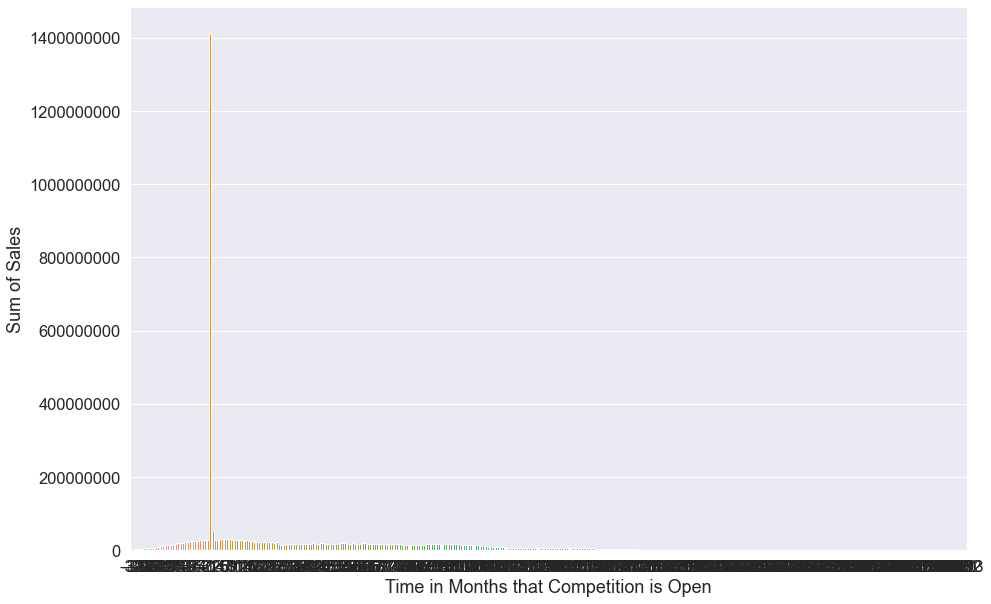

In [54]:
# checking 'sales' by 'competition_open_timeinmonths'
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
sns.barplot(data = aux1, x='competition_open_timeinmonths', y='sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');
plt.ticklabel_format(style='plain', axis='y');

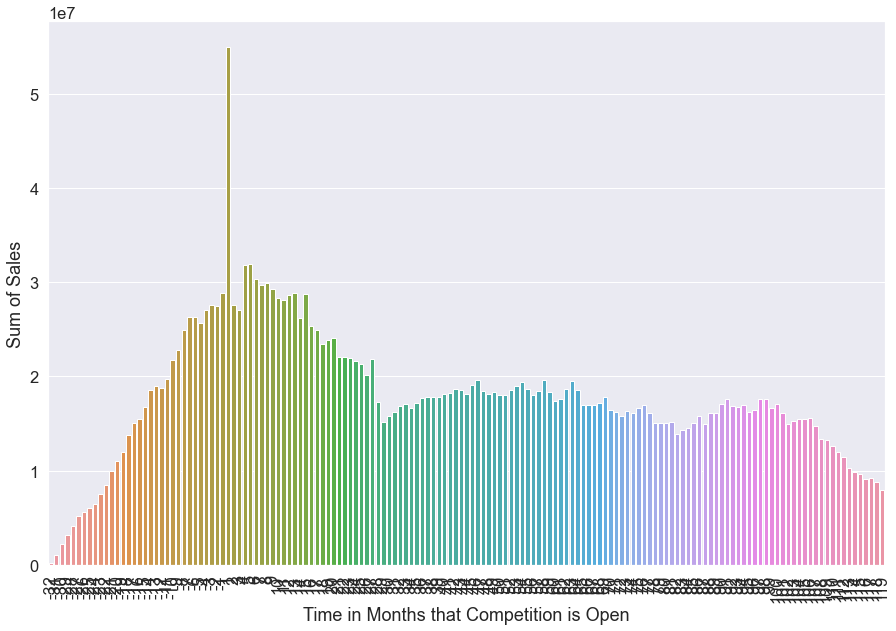

In [55]:
# checking 'competition_open_timeinmonths' for less than 120 months
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
aux2 = aux1[( aux1['competition_open_timeinmonths']<120 ) & ( aux1['competition_open_timeinmonths'] != 0)]

sns.barplot(data = aux2, x='competition_open_timeinmonths', y='sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');
plt.xticks(rotation=90);

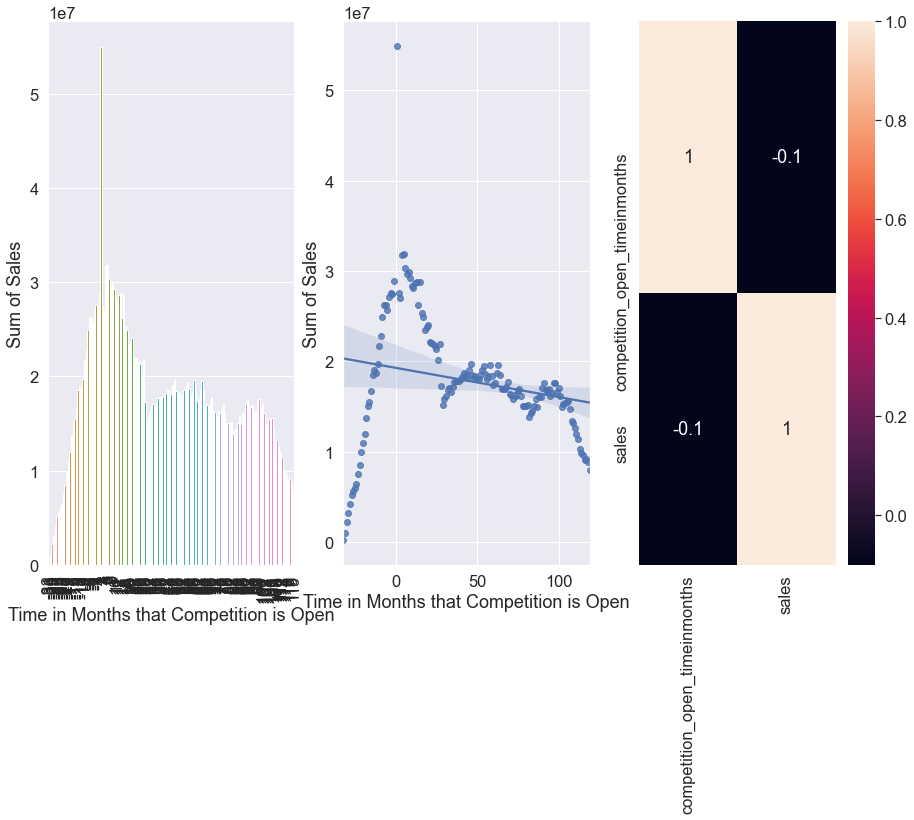

In [61]:
plt.subplot(1,3,1)
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
aux2 = aux1[( aux1['competition_open_timeinmonths']<120 ) & ( aux1['competition_open_timeinmonths']!=0)]
sns.barplot(data = aux2, x='competition_open_timeinmonths', y='sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(data = aux2, x='competition_open_timeinmonths', y='sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### Stores with longer active promotions should sell more
**False:** Stores with longer active promotions sell less after a certain period of time.

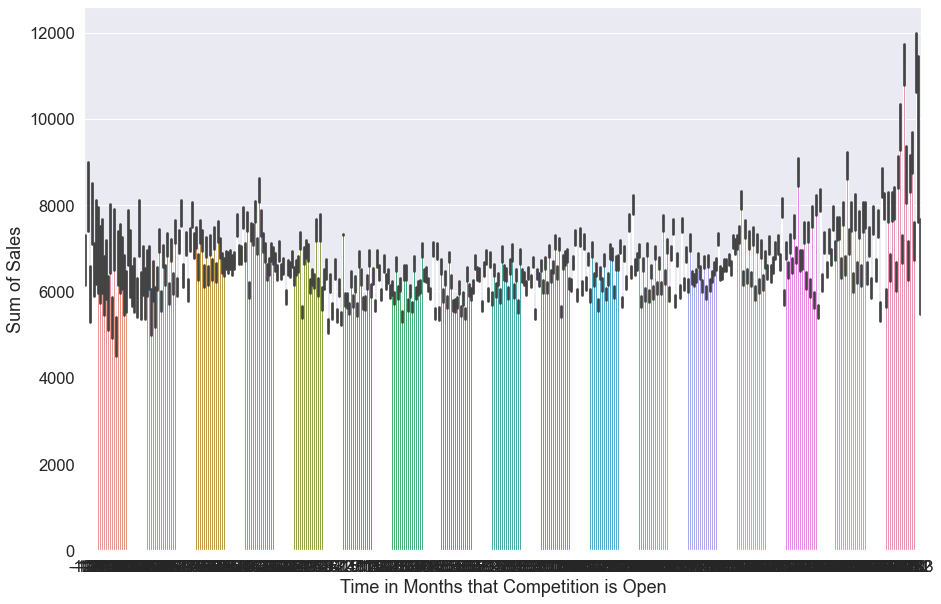

In [57]:
# checking 'sales' by 'promo_since_timeinweeks'
aux1 = df4[['promo_since_timeinweeks','sales']].groupby('promo_since_timeinweeks').sum().reset_index()
sns.barplot(data=df4, x = 'promo_since_timeinweeks', y = 'sales').set(xlabel='Time in Months that Competition is Open', ylabel='Sum of Sales');

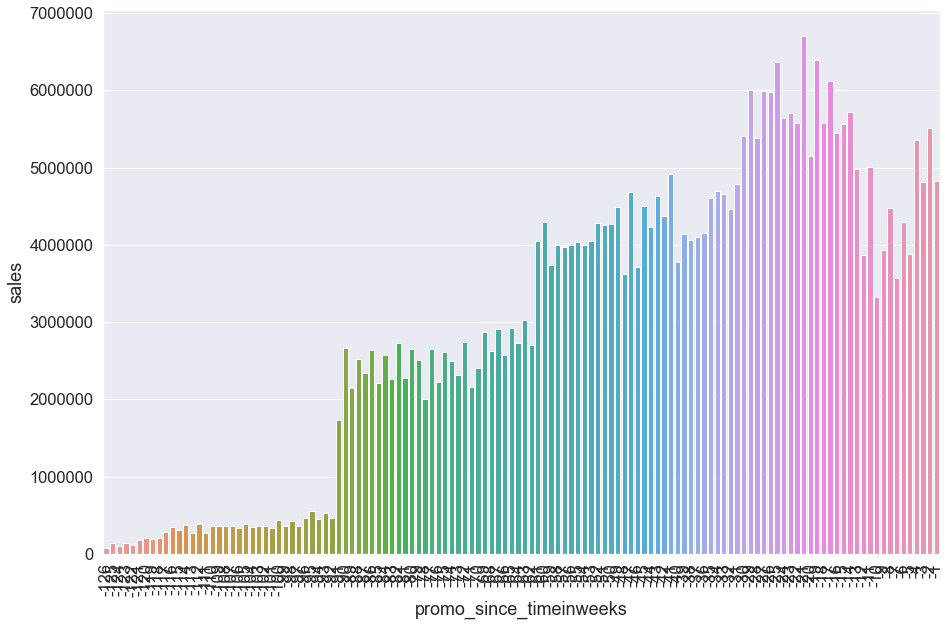

In [58]:
aux3 = aux1[aux1['promo_since_timeinweeks'] < 0] # promotions started after sales
sns.barplot(data=aux3, x='promo_since_timeinweeks', y='sales');
plt.ticklabel_format(style='plain', axis='y');
plt.xticks(rotation = 90);

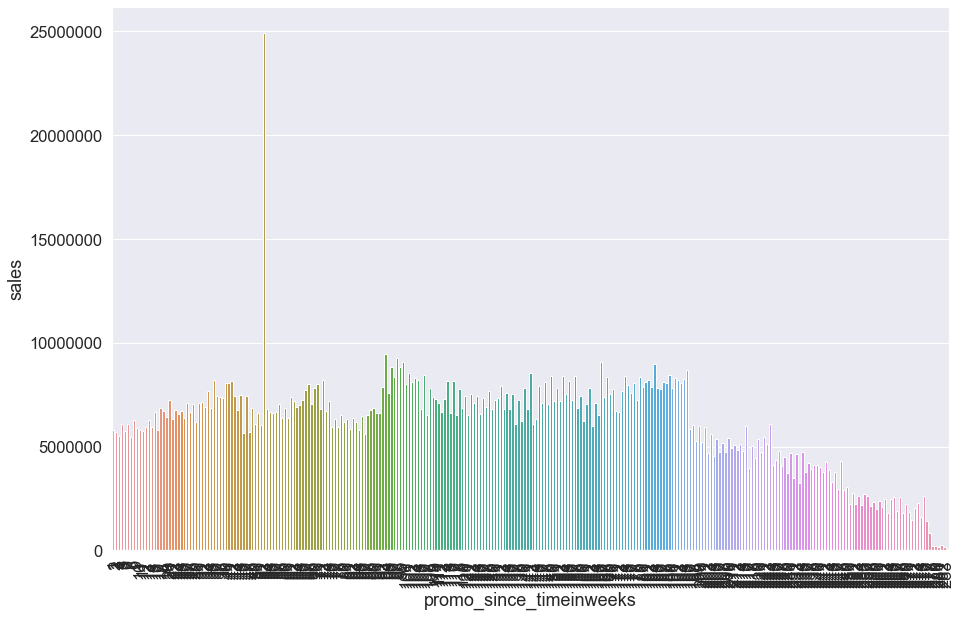

In [59]:
aux2 = aux1[aux1['promo_since_timeinweeks'] > 0] # promotions started before sales
sns.barplot(data=aux2, x='promo_since_timeinweeks', y='sales');
plt.ticklabel_format(style='plain', axis='y');
plt.xticks(rotation = 90);

### Stores with more consecutive promotions should sell more
**False:** Stores with more consecutive promotions sell less.

In [62]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().sort_values('sales', ascending=True).reset_index()

,promo,promo2,sales
0,0,1,987928378
1,1,1,1102311941
2,0,0,1153307565
3,1,0,1240133096


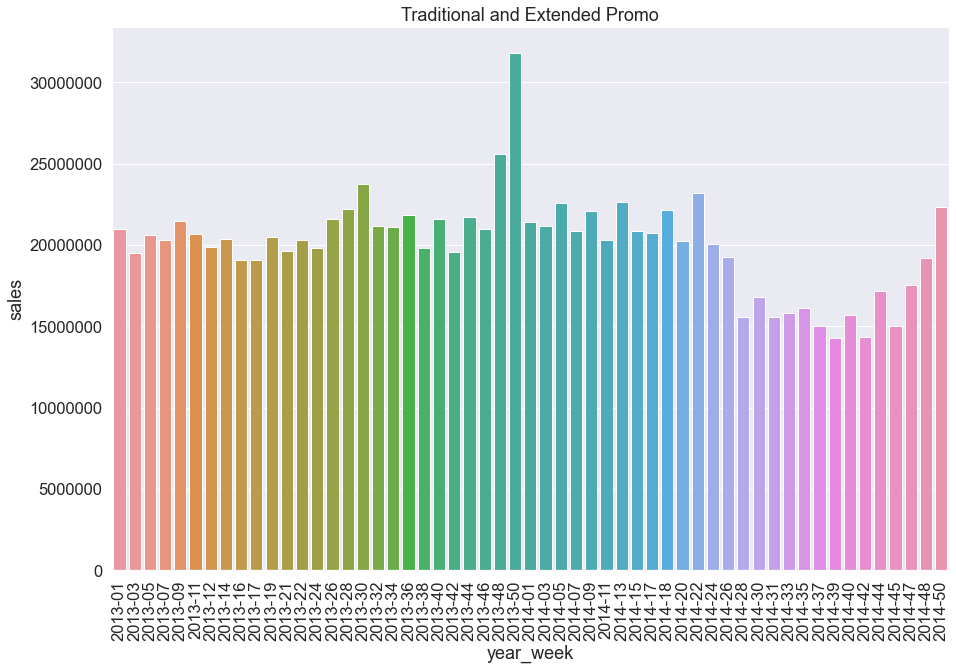

In [63]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
sns.barplot(data=aux1, x ='year_week', y = 'sales');
plt.xticks(rotation = 90);
#display(aux1.head())

plt.ticklabel_format(style='plain', axis='y');
plt.xlabel('year_week');
plt.ylabel('sales');
plt.title('Traditional and Extended Promo');

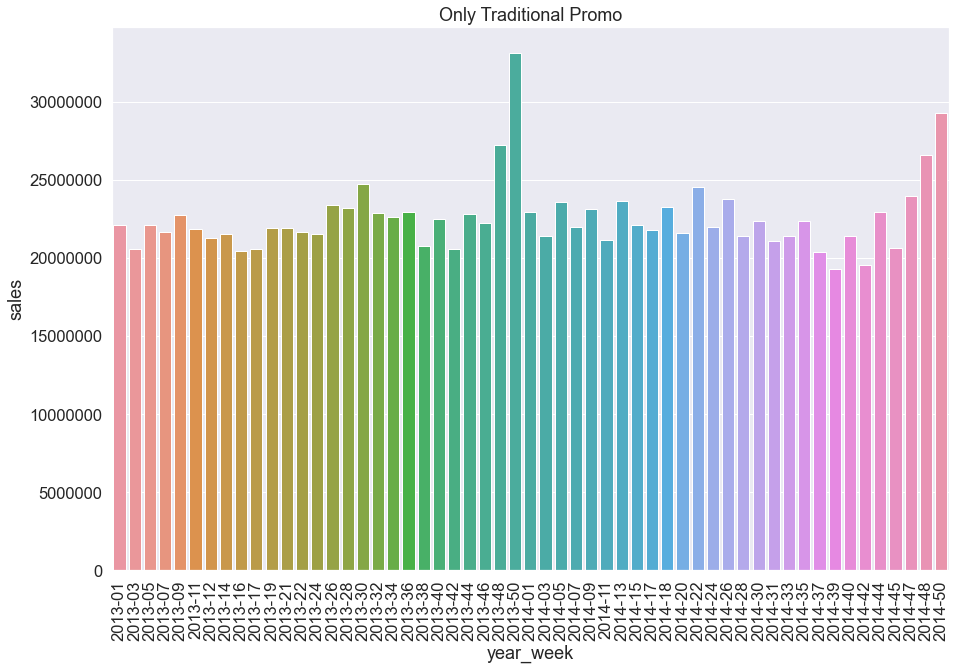

In [64]:
# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
sns.barplot(data=aux2, x ='year_week', y = 'sales');
plt.xticks(rotation = 90);
#display(aux2.head())

plt.ticklabel_format(style='plain', axis='y');
plt.xlabel('year_week');
plt.ylabel('sales');
plt.title('Only Traditional Promo');

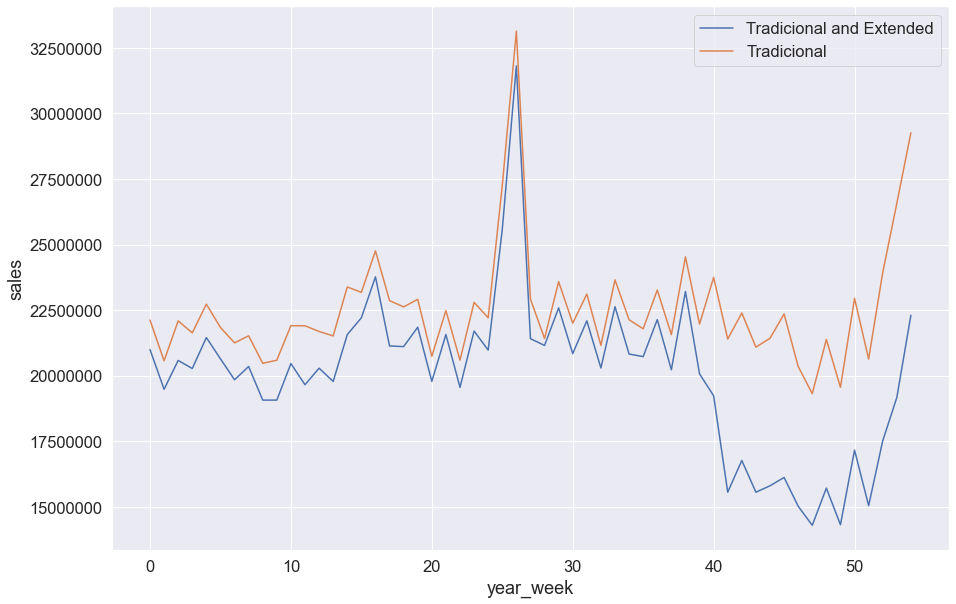

In [65]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

plt.ticklabel_format(style='plain', axis='y');
ax.legend(labels = ['Tradicional and Extended', 'Tradicional']);
plt.xlabel('year_week');
plt.ylabel('sales');

###  Stores sell more during the Christmas holiday than during other holidays
**True:** Stores sell more during the Christmas holiday than during other holidays

,state_holiday,sales
0,Christmas,9743.75
1,Easter holiday,9566.15
2,Public holiday,8257.53


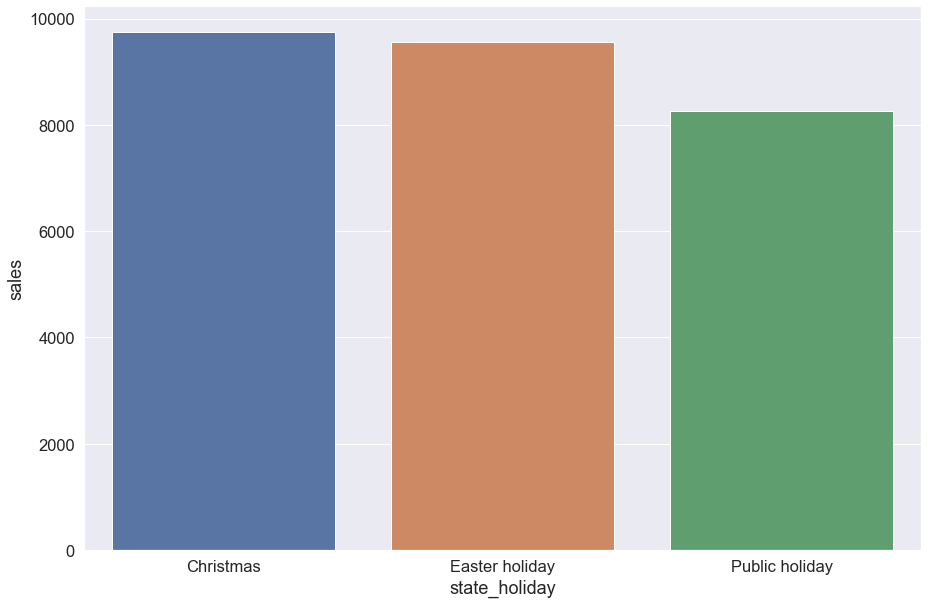

In [66]:
# checking 'sales' by 'state_holiday'
aux = df4[df4['state_holiday'] != 'regular day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(data = aux1, x = 'state_holiday', y = 'sales');

display(aux1)

### Stores should sell more over the years
**False:** Stores are selling less over the years.

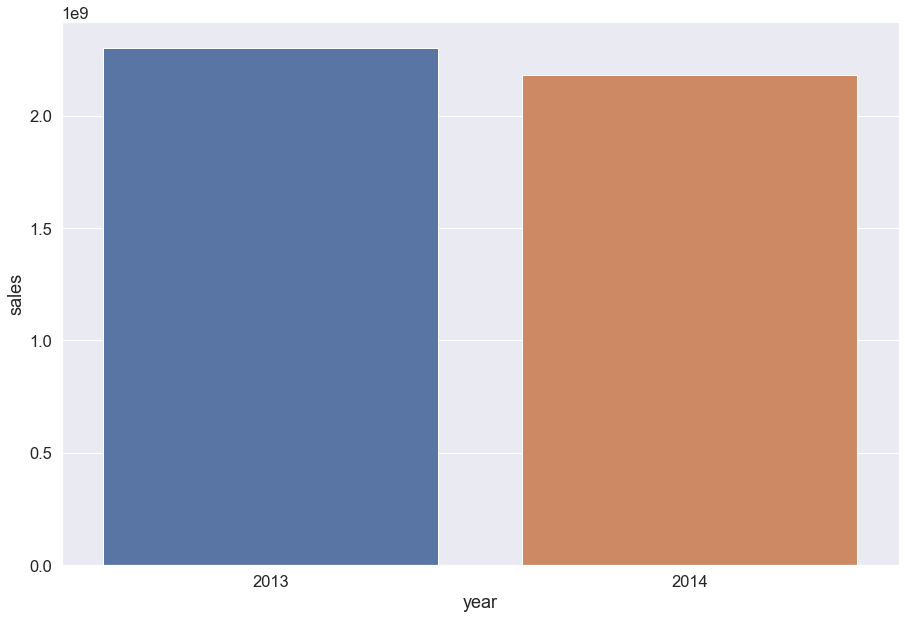

In [67]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

sns.barplot(data=aux1, x='year', y='sales');

### Stores should sell more in the second semester
**True:** Stores sell more in the second semester.

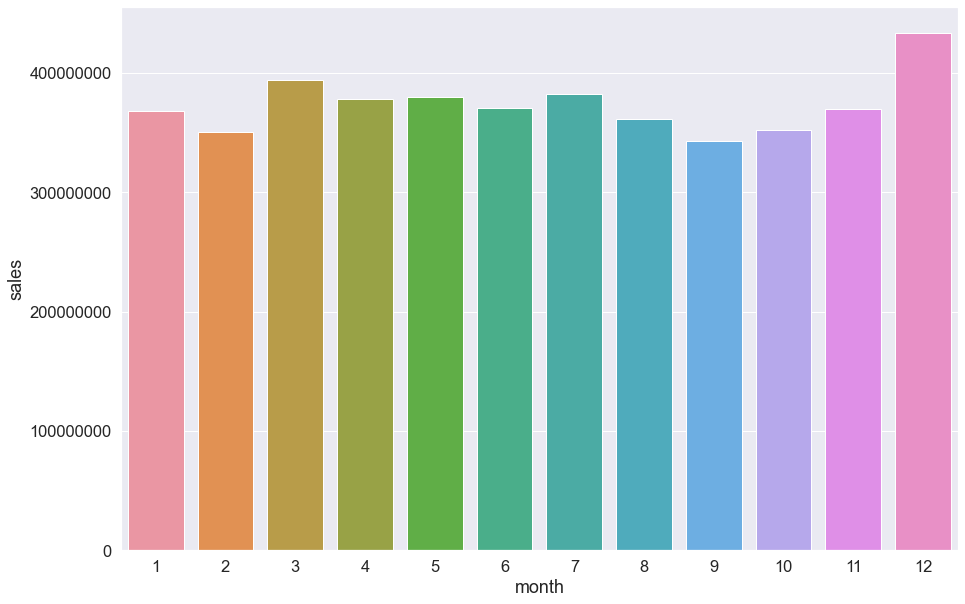

In [68]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(data = aux1, x = 'month', y = 'sales');
plt.ticklabel_format(style='plain', axis='y');

# próximo ciclo agrupar vendas de meses 1 a 6 e 7 a 12

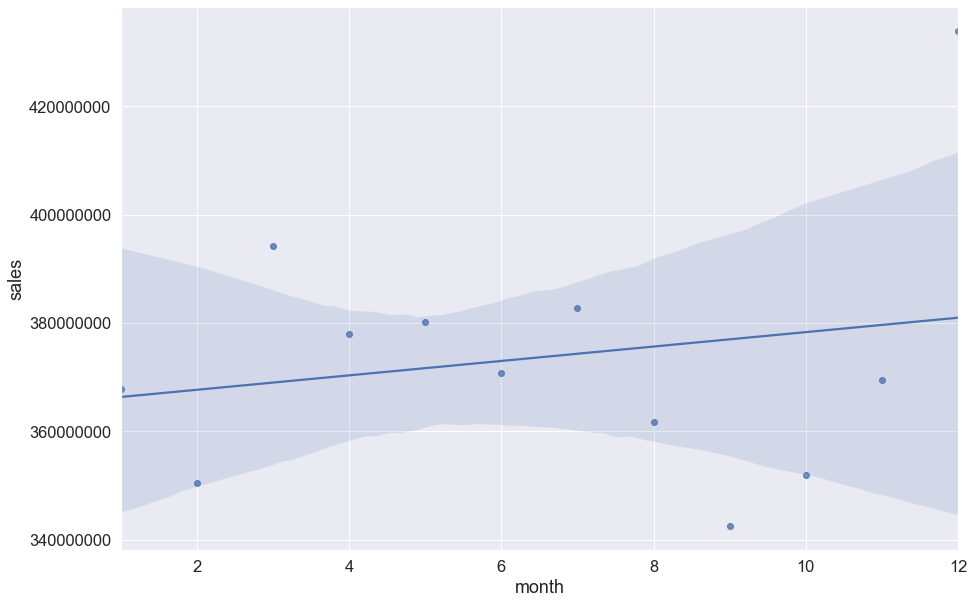

In [69]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.regplot(data = aux1, x = 'month', y = 'sales');
plt.ticklabel_format(style='plain', axis='y');



,month_binned,sales
1,"(6, 12]",2242306680
0,"(0, 6]",2241374300


Sales difference between 2nd Semester and 1st Semester: R$932,380.00


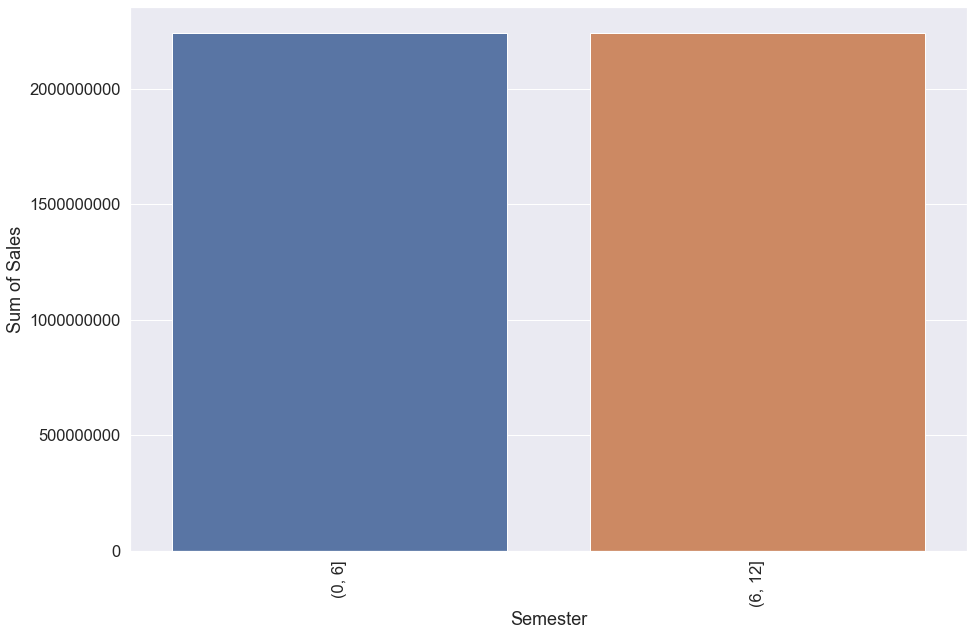

In [70]:
# grouping 'month' in bins
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
aux1

bingroup = list (np.arange(0,13,6))
aux1['month_binned'] = pd.cut(aux1['month'], bins = bingroup)
aux1

aux2 = aux1[['month_binned','sales']].groupby('month_binned').sum().reset_index()
display(aux2.sort_values('sales', ascending=False))

sns.barplot(data=aux2, x='month_binned', y='sales').set(xlabel='Semester', ylabel='Sum of Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90);

print('Sales difference between 2nd Semester and 1st Semester: R${:,.2f}'.format(aux2['sales'].max() - aux2['sales'].min()))

### Stores should sell more after the 10th of each month
**False:** Stores sell less after the 10th of each month.

,before_after10,sales
1,before_day10,7276.14
0,after_day10,6771.38


Sales difference between before and after 10th of each month: R$504.77


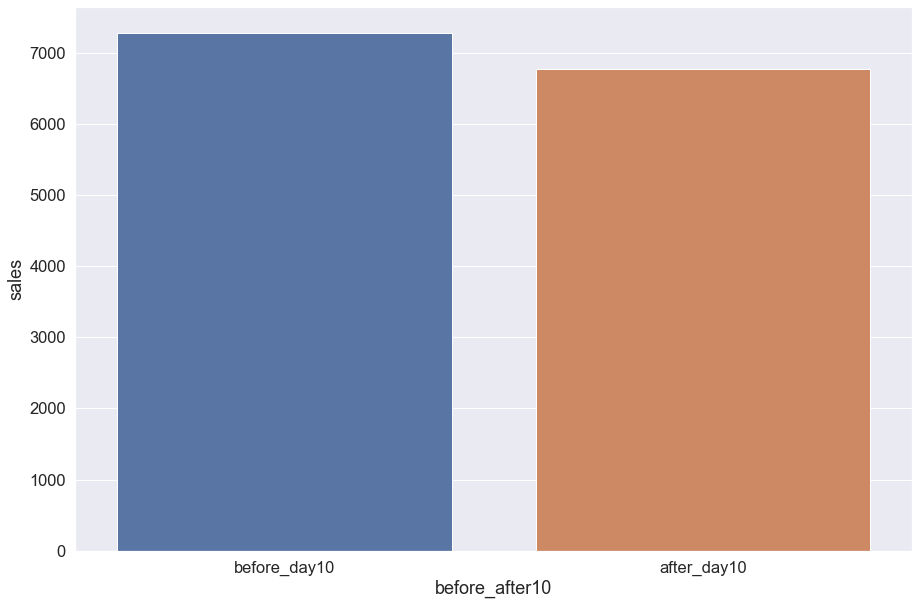

In [71]:
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()
aux1['before_after10'] = aux1['day'].apply (lambda x: 'before_day10' if x <= 10 else 'after_day10')
aux1

aux2 = aux1[['before_after10','sales']].groupby('before_after10').mean().reset_index()
display(aux2.sort_values('before_after10', ascending=False))
sns.barplot(data=aux2, x='before_after10', y='sales', order=['before_day10', 'after_day10']);

print('Sales difference between before and after 10th of each month: R${:,.2f}'.format(aux2['sales'][1] - aux2['sales'][0]))

# próximo ciclo: calcular média de vendas por dia nos dez primeiros dias, e depois a média de vendas nos demais vinte dias, ou fazer três grupos de 10 dias cada.

### Stores should sell less on weekends
**False:** Stores sell more on weekends.

Average sales during the week:  R$7,135.22
Average sales during the weekend:  R$8,084.93

Sales difference between weekend and week days: R$949.71


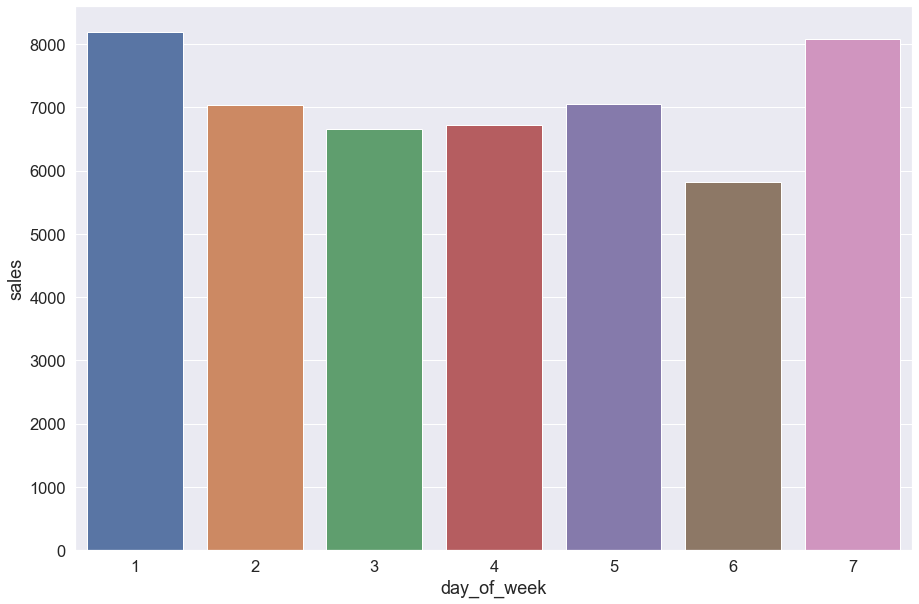

In [73]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

sns.barplot(data=aux1, x='day_of_week', y='sales');
plt.ticklabel_format(style='plain', axis='y');

avg_weekday = aux1[aux1['day_of_week']<6]['sales'].mean()
avg_weekend = aux1[aux1['day_of_week']>6]['sales'].mean()

print('Average sales during the week:  R${:,.2f}'.format(avg_weekday))
print('Average sales during the weekend:  R${:,.2f}'.format(avg_weekend))
print('\nSales difference between weekend and week days: R${:,.2f}'.format(avg_weekend - avg_weekday))

# próximo ciclo: avaliar a frequência que as lojas ficam abertas aos fins de semana.

### Stores should sell less during school holidays
**False:** Stores sell more during school holidays.

,school_holiday,sales
0,0,6875.13
1,1,7075.88


Sales difference between other days and school holidays: R$364.29


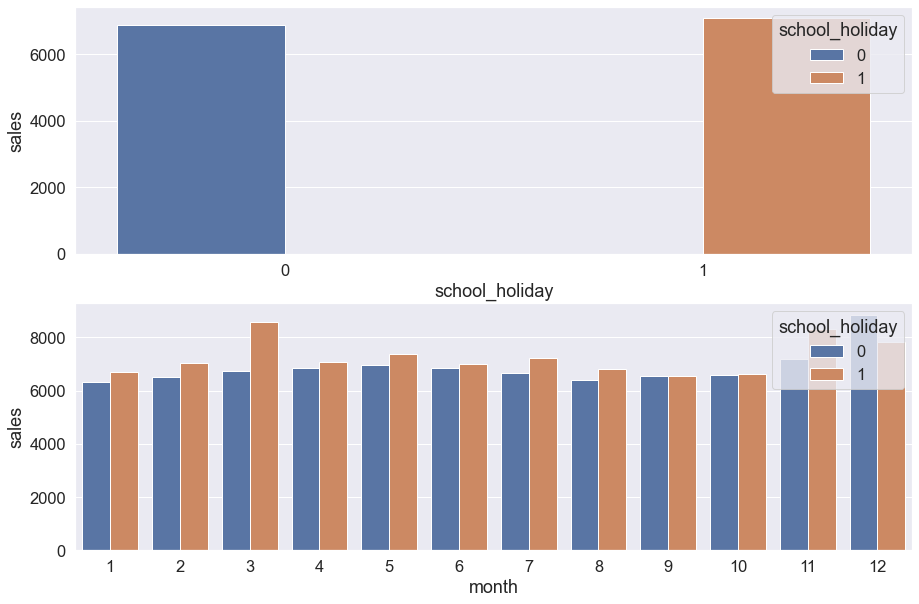

In [74]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()
display(aux1)

plt.subplot(2,1,1)
sns.barplot(data=aux1, x='school_holiday', y='sales', hue='school_holiday')

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(data= aux2, x='month', y='sales', hue='school_holiday');

print('Sales difference between other days and school holidays: R${:,.2f}'.format(aux2['sales'][1] - aux2['sales'][0]))


# próximo ciclo: fazer média de vendas em dias comuns vs. média de vendas em dias de feriados escolares.

## Multivariate Analysis

### Numerical Attributes

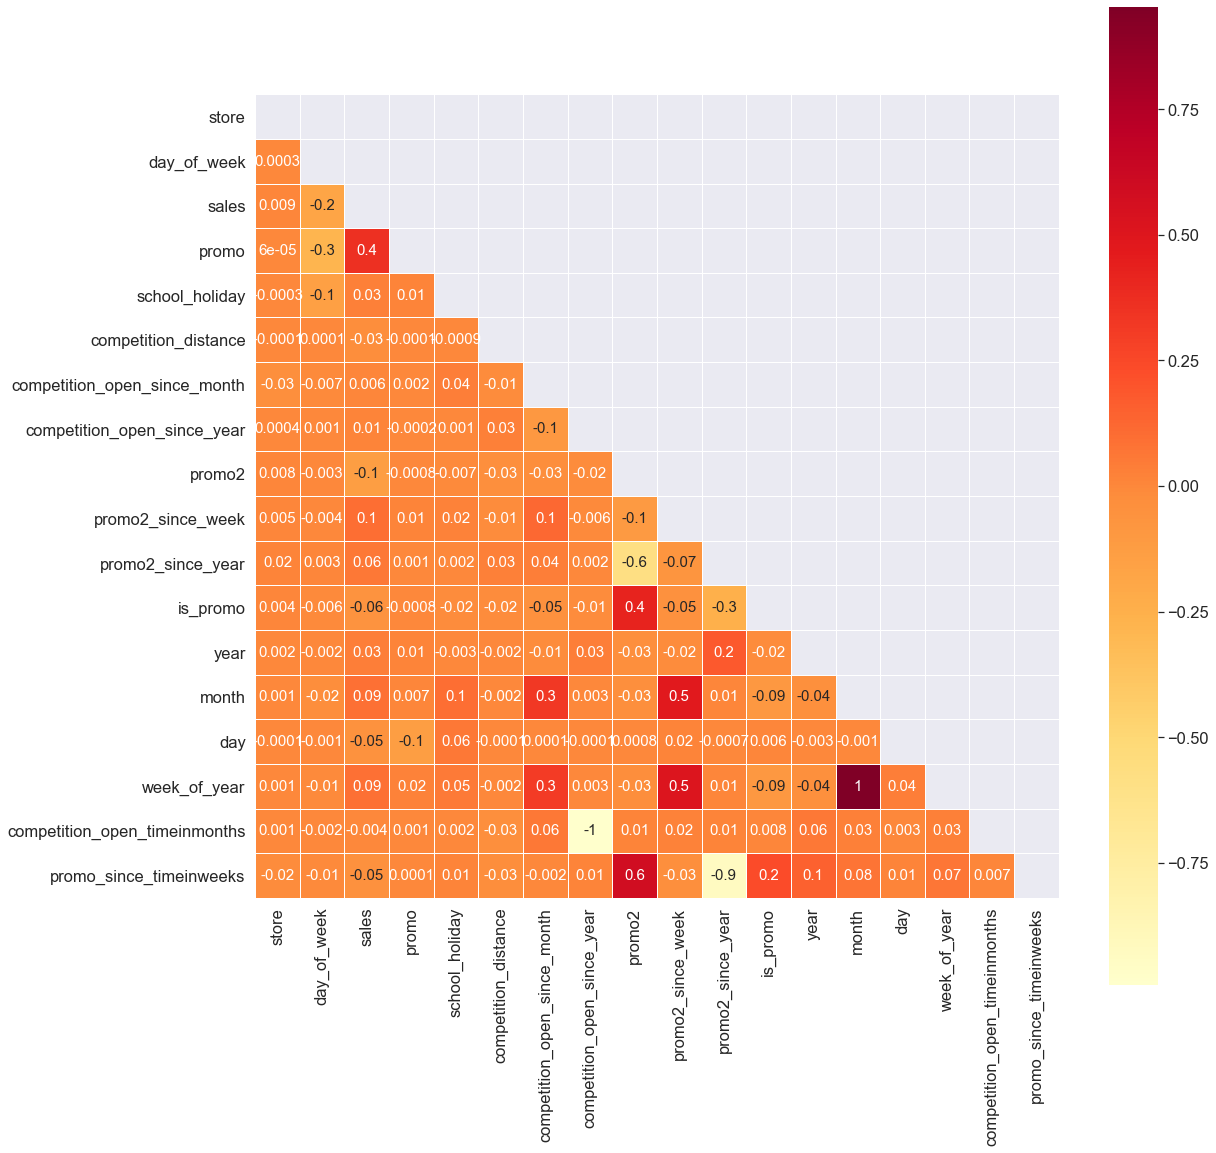

In [75]:
correlation = num_df4.corr(method = 'pearson')

corr_mask = np.triu(correlation)

plt.figure(figsize=(18,18))
sns.heatmap(correlation, 
            cmap='YlOrRd', 
            annot=True, 
            annot_kws={'fontsize':'small'},
            fmt='.1g',
            linewidths=0.8, 
            square=True,
            mask=corr_mask);

### Categorical Attributes

In [ ]:
df4.dtypes

               state_holiday  store_type  assortment
state_holiday           1.00        0.07        0.07
store_type              0.07        1.00        0.54
assortment              0.07        0.54        1.00 



<AxesSubplot:>

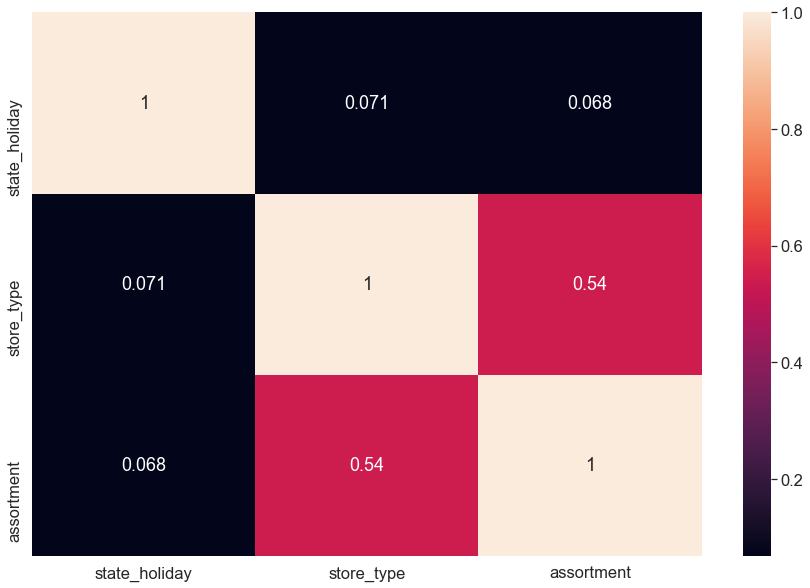

In [76]:
# calculating Cramer V (formula at Helper Function section)

a1 = cramer_v(cat_df4['state_holiday'], cat_df4['state_holiday'])
a2 = cramer_v(cat_df4['state_holiday'], cat_df4['store_type'])
a3 = cramer_v(cat_df4['state_holiday'], cat_df4['assortment'])

a4 = cramer_v(cat_df4['store_type'], cat_df4['state_holiday'])
a5 = cramer_v(cat_df4['store_type'], cat_df4['store_type'])
a6 = cramer_v(cat_df4['store_type'], cat_df4['assortment'])

a7 = cramer_v(cat_df4['assortment'], cat_df4['state_holiday'])
a8 = cramer_v(cat_df4['assortment'], cat_df4['store_type'])
a9 = cramer_v(cat_df4['assortment'], cat_df4['assortment'])

# final dataset 
t = pd.DataFrame({'state_holiday': [ a1,a2,a3],
                  'store_type':    [ a4,a5,a6],
                  'assortment':    [ a7,a8,a9]})

t = t.set_index(t.columns)
print (t, '\n')

sns.heatmap (data=t, annot=True)

# DATA PREPARATION

In [77]:
df5=df4.copy()

## Rescaling

In [78]:
num_df5 = df5.select_dtypes(include=['int64','float64'])
num_df5.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_open_timeinmonths,promo_since_timeinweeks
236380,1,3,2605,0,1,1270.00,9,2008,0,1,2014,0,2014,12,31,1,77,52
236381,2,3,2269,0,1,570.00,11,2007,1,13,2010,0,2014,12,31,1,87,249
236382,3,3,3804,0,1,14130.00,12,2006,1,14,2011,0,2014,12,31,1,98,196
236383,4,3,10152,0,1,620.00,9,2009,0,1,2014,0,2014,12,31,1,64,52
236384,5,3,1830,0,1,29910.00,4,2015,0,1,2014,0,2014,12,31,1,-4,52


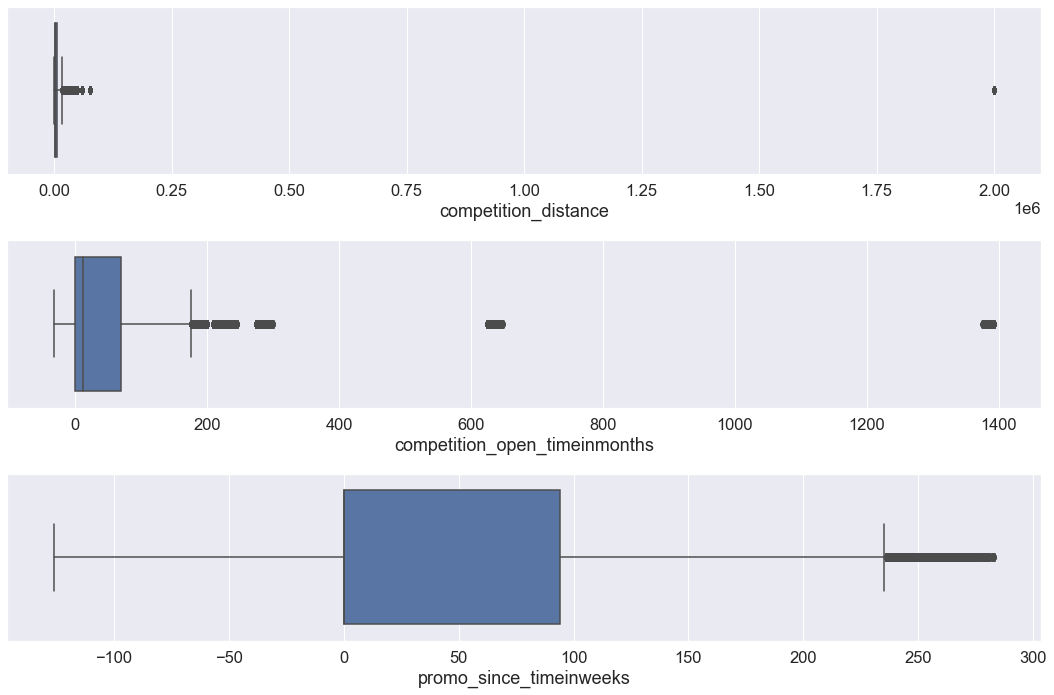

In [79]:
# checking outliers

# competition_distance
plt.subplot(3,1,1)
sns.boxplot(data=df5, x=df5['competition_distance']);

# competition_open_timeinmonths
plt.subplot(3,1,2)
sns.boxplot(data=df5, x=df5['competition_open_timeinmonths']);

# promo_since_timeinweeks
plt.subplot(3,1,3)
sns.boxplot(data=df5, x=df5['promo_since_timeinweeks']);

plt.tight_layout()

In [80]:
# rescaling

rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_open_timeinmonths
df5['competition_open_timeinmonths'] = rs.fit_transform(df5[['competition_open_timeinmonths']].values)

# promo_since_timeinweeks
df5['promo_since_timeinweeks'] = mms.fit_transform(df5[['promo_since_timeinweeks']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)



df5[['competition_distance', 'competition_open_timeinmonths', 'promo_since_timeinweeks']].head()

,competition_distance,competition_open_timeinmonths,promo_since_timeinweeks
236380,-0.17,0.93,0.44
236381,-0.28,1.07,0.92
236382,1.90,1.23,0.79
236383,-0.28,0.74,0.44
236384,4.45,-0.23,0.44


## Transforming

### Encoding

In [83]:
df52 = df5.copy()

cat_df5 = df5.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
cat_df5.head()

,state_holiday,store_type,assortment,year_week
236380,regular day,c,basic,2014-52
236381,regular day,a,basic,2014-52
236382,regular day,a,basic,2014-52
236383,regular day,c,extended,2014-52
236384,regular day,a,basic,2014-52


In [84]:
# state_holiday - one hot enconding (each holiday becomes a column)
df52 = pd.get_dummies(df52, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - label enconding (each type becomes a value in a range)
le = preprocessing.LabelEncoder()
df52['store_type'] = le.fit_transform(df52['store_type'])

# assortment - ordinal enconding (each assortment becomes a value in a hierarchy)
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df52['assortment'] = df52['assortment'].map(assortment_dict)

df52.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_open_since,competition_open_timeinmonths,promo_since,promo_since_timeinweeks,state_holiday_Christmas,state_holiday_Easter holiday,state_holiday_Public holiday,state_holiday_regular day
236380,1,3,2014-12-31,2605,0,1,2,1,-0.17,9,...,1,2014-52,2008-09-01,0.93,2013-12-30,0.44,0,0,0,1
236381,2,3,2014-12-31,2269,0,1,0,1,-0.28,11,...,1,2014-52,2007-11-01,1.07,2010-03-22,0.92,0,0,0,1
236382,3,3,2014-12-31,3804,0,1,0,1,1.90,12,...,1,2014-52,2006-12-01,1.23,2011-03-28,0.79,0,0,0,1
236383,4,3,2014-12-31,10152,0,1,2,3,-0.28,9,...,1,2014-52,2009-09-01,0.74,2013-12-30,0.44,0,0,0,1
236384,5,3,2014-12-31,1830,0,1,0,1,4.45,4,...,1,2014-52,2015-04-01,-0.23,2013-12-30,0.44,0,0,0,1


### Response Variable Transformation

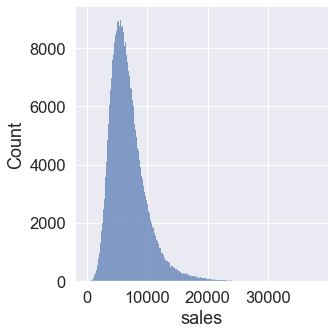

In [85]:
sns.displot(df52['sales']);

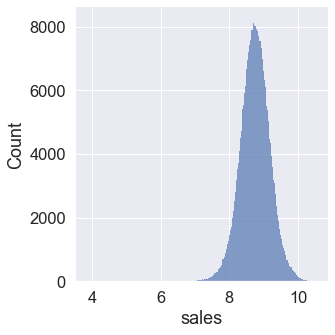

In [86]:
df52['sales'] = np.log1p(df52['sales'])
sns.displot(df52['sales']);

### Nature Transformation

In [87]:
# month
df52['month_sin'] = df52['month'].apply(lambda x: np.sin(x*(2*np.pi/12))) 
df52['month_cos'] = df52['month'].apply(lambda x: np.cos(x*(2*np.pi/12))) 

# week_of_year
df52['week_of_year_sin'] = df52['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52))) 
df52['week_of_year_cos'] = df52['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52))) 

# day
df52['day_sin'] = df52['day'].apply(lambda x: np.sin(x*(2*np.pi/30))) 
df52['day_cos'] = df52['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# day_of_week
df52['day_of_week_sin'] = df52['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7))) 
df52['day_of_week_cos'] = df52['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))



df52.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_Public holiday,state_holiday_regular day,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
236380,1,3,2014-12-31,7.87,0,1,2,1,-0.17,9,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90
236381,2,3,2014-12-31,7.73,0,1,0,1,-0.28,11,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90
236382,3,3,2014-12-31,8.24,0,1,0,1,1.90,12,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90
236383,4,3,2014-12-31,9.23,0,1,2,3,-0.28,9,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90
236384,5,3,2014-12-31,7.51,0,1,0,1,4.45,4,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90


# FEATURE SELECTION

In [88]:
df6 = df52.copy()
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_Public holiday,state_holiday_regular day,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
236380,1,3,2014-12-31,7.87,0,1,2,1,-0.17,9,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90
236381,2,3,2014-12-31,7.73,0,1,0,1,-0.28,11,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90
236382,3,3,2014-12-31,8.24,0,1,0,1,1.90,12,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90
236383,4,3,2014-12-31,9.23,0,1,2,3,-0.28,9,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90
236384,5,3,2014-12-31,7.51,0,1,0,1,4.45,4,...,0,1,-0.00,1.00,0.12,0.99,0.21,0.98,0.43,-0.90


## Training and Test dataset

In [89]:
# deleting columns that derived other features
dropcols = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_open_since', 'year_week']
df6 = df6.drop(dropcols, axis=1)
df6.shape

(648309, 29)

In [90]:
# Checking 'date' intervals
print(df6[['store', 'date']].groupby('store').min().reset_index()['date'][0], '-> First date')
print(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0], '-> Last date', )
print(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7), '-> Six weeks before last date')

2013-01-02 00:00:00 -> First date
2014-12-31 00:00:00 -> Last date
2014-11-19 00:00:00 -> Six weeks before last date


In [91]:
# Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print()
print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2014-12-31 00:00:00

Test Min Date: NaT
Test Max Date: NaT


## Boruta as Feature Selection

In [93]:
# training and test datset for Boruta
X_train_blist = X_train.drop(['date', 'sales'], axis=1).values # array
Y_train_blist = Y_train.values.ravel() # array

# defining Radom Forest Regressor
rf = RandomForestRegressor(n_jobs=-1) # pararel processing

# defining Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_blist, Y_train_blist)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
I

In [97]:
cols_selected_blist = boruta.support_.tolist() # list of features boruta selected in boolean format
X_train_FS = X_train.drop(['date', 'sales'], axis=1) # deleting cols from X_train to read next step

# Features Selected from Boruta
cols_selected_boruta = X_train_FS.iloc[:, cols_selected_blist].columns.to_list() # list of columns boruta selected

# Features not Selected from Boruta
cols_notselected_boruta = list(np.setdiff1d(X_train_FS.columns, cols_selected_boruta)) # list of columns boruta did not select

## Manual Feature Selection

In [98]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timeinmonths',
 'promo_since_timeinweeks',
 'month_cos',
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [99]:
# Features Selected from Boruta
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timeinmonths',
 'promo_since_timeinweeks',
 'month_sin', # added manually
 'month_cos',
 'week_of_year_sin', # added manually
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# features to add
features_added = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(features_added)

cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timeinmonths',
 'promo_since_timeinweeks',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']